# LORA fine tuning for LLM extractive question answering

In this tutorial, you will fine-tune an LLM using LORA. The dataset being used is from https://www.kaggle.com/datasets/jpmiller/layoutlm?select=medquad.csv however, it has been adapted for an extractive question-answering task. Extractive question answering, assumes a question $q \in Q$ and a context $c \in C$ is given to the model $f$ and the model must output an answer $a \subseteq c$ which is contained in the context. A concrete usecase of such a setup is a traditional FAQ with a free text input. Whilst there are numerous other ways to develop such a product (e.g., RAG), we'll focus on extractive Q&A by finetuning an LLM as an example use of LORA. However, this task will demonstrate the ambiguity/challenge of text based metrics for evaluation which remains an active research area.

## Load dependancies

In [1]:
!pip install accelerate evaluate datasets peft
# Load from transformers from github due to issue:
# https://github.com/huggingface/transformers/issues/34701
!pip install git+https://github.com/huggingface/transformers
!pip install --force-reinstall git+https://github.com/joshuaspear/pymlrf.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-kmk_zsx

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from pymlrf.FileSystem import DirectoryHandler
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
import pandas as pd
import re
from typing import List, Dict, overload
import wandb
import os
from tqdm import tqdm
import transformers
import accelerate
import peft
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import pipeline
import evaluate
import random
from peft import LoraConfig, get_peft_model
import pyarrow as pa
import pyarrow.dataset as ds
from datasets import Dataset
from transformers.pipelines.pt_utils import KeyDataset
import numpy as np
import copy
import json

2024-12-13 06:27:23,244 - pymlrf - WARNING - pymlrf environment variable not set. Logging to file will not be performed (__init__.py:47)


## Setup
For training and validation, we'll use the HuggingFace API. Additionally, we'll save the best model to your HuggingFace profile. To do this, you'll need to sign into HuggingFace using ```notebook_login()``` below. The Trainer API from HuggingFace abstracts away a number of infrastructure challanges e.g., half-precisions. To alter the wandb parameters of the Trainer API, we will use environment variables which are defined using ```os.environ```

In [4]:
os.environ["WANDB_PROJECT"] = "week10_tutorial_llm_BERT"
os.environ["WANDB_LOG_MODEL"] = "checkpoint"

In [5]:
from huggingface_hub import notebook_login
notebook_login()

## LORA overview
The aim of LORA is to reduce the memory and computational requirements of finetuning. When niavely training a model (i.e., without additional tricks), the entire model is placed on a GPU. However, since training requires computing gradients, this gradient information additionally needs to be stored on the GPU, further reducing the model size that can be trained. For a specific downstream task, LORA posits that additional updates to the weights of a network are defined by a subspace of the weights with rank significantly lower than the full weight matrix. Alternatively, for a specific downstream task, we are only interested in updating the weights in a subset of directions. A such, LORA posits freezing the base model weights and training an additional set of weights that will be added to the original weights. For a given weight matrix, the computation becomes: $h = W_{0}x + \Delta Wx = W_{0}x + \Delta BAx$ where $W_{0}$ is the original weight matrix and $W$ is the LORA weight, decomposed into $BA$. If $W_{0}\in \mathbb{R}^{d\times  k}$ then $B\in \mathbb{R}^{d\times  r}, A\in \mathbb{R}^{r\times  k}$. $r$ thus defines the rank of the LORA weight and defines a trade off between lower memory and higher computational speed (decreasing $r$) with increased learning capacity (increasing $r$). LORA additionally includes an $\alpha$ parameter which scales the learned weights ($BA$) when adding them to the base weights. This is generally set equal to the LORA rank however, a higher $\alpha$ will place greater emphasis on the learned weights.

## Import and setup data

In [6]:
ROOT_DIR = "drive/MyDrive/comp0188_2425/Tutorials/Josh"
#data_dh = DirectoryHandler(loc=os.path.join(ROOT_DIR,"med_quad"))
data_dh = DirectoryHandler(loc=ROOT_DIR)

In [7]:
with open(os.path.join(data_dh.loc, "COVID-QA.json"), "r") as f:
  data = json.load(f)


questions = []
answers = []
contexts = []

for entry in data['data']:
  for paragraph in entry['paragraphs']:
    context = paragraph['context']
    for qa in paragraph['qas']:
      questions.append(qa['question'])
      answers.append(qa['answers'][0]['text'])
      contexts.append(context)


all_data = pd.DataFrame({
  'question': questions,
  'answer': answers,
  'context': contexts
})

#all_data = pd.read_csv(os.path.join(data_dh.loc, 'medquad.csv'))
all_data["answer"] = all_data["answer"].astype(str)
print(all_data.shape)
all_data = all_data.drop_duplicates()
print(all_data.shape)

_ids = all_data.groupby(by=["question"], as_index=False).size()
_ids["size"] = _ids["size"].cumsum()

# Define the index where the answers begins in the query
all_data["answer_start"] = all_data.apply(
    lambda x: x["context"].find(x["answer"]),
    axis=1
    )
# Define the index where the answers ends in the query
all_data["answer_end"] = all_data.apply(
    lambda x: x["answer_start"]+len(x["answer"]),
    axis=1
)

all_data = all_data.merge(
    _ids,
    left_on="question",
    right_on="question",
    how="left"
    )

all_data = all_data.rename(columns={"size":"id"})
all_data.head()

(2019, 3)
(2019, 3)


,question,answer,context,answer_start,answer_end,id
0,What is the main cause of HIV-1 infection in c...,Mother-to-child transmission (MTCT) is the mai...,Functional Genetic Variants in DC-SIGNR Are As...,370,466,1239
1,What plays the crucial role in the Mother to C...,DC-SIGNR plays a crucial role in MTCT of HIV-1...,Functional Genetic Variants in DC-SIGNR Are As...,2003,2129,1471
2,How many children were infected by HIV-1 in 20...,"more than 400,000 children were infected world...",Functional Genetic Variants in DC-SIGNR Are As...,2291,2408,248
3,What is the role of C-C Motif Chemokine Ligand...,"High copy numbers of CCL3L1, a potent HIV-1 su...",Functional Genetic Variants in DC-SIGNR Are As...,28143,28323,1314
4,What is DC-GENR and where is it expressed?,Dendritic cell-specific ICAM-grabbing non-inte...,Functional Genetic Variants in DC-SIGNR Are As...,3207,3479,926


The data we are using consists of a set of question and answers relating to healthcare queries. Since we are performing extractive question and answering, we'll create a mock context defined by all of the answers related to a given condition. Additionally, we'll add some helper variables which will be useful later.

In [8]:
# Check we've created these indices properly!
print(len(all_data.iloc[0]["answer"]))
print(len(all_data.iloc[0]["context"][all_data.iloc[0]["answer_start"]:all_data.iloc[0]["answer_end"]]))

96
96


In [9]:
# Load data

_train_idx, test_idx = train_test_split(
    all_data.index,
    test_size=0.1,
    random_state=42,
    shuffle=True
    )
train_idx, val_idx = train_test_split(
    _train_idx,
    test_size=0.1,
    random_state=42,
    shuffle=True
    )


SUBSET = False
if SUBSET:
    train_idx = train_idx[0:min(500, len(train_idx))]
    val_idx = val_idx[0:min(100, len(val_idx))]
    test_idx = test_idx[0:min(100, len(test_idx))]

print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Validation size: {len(test_idx)}")

train = Dataset.from_pandas(
    all_data.loc[train_idx].reset_index(drop=True)
    )

validation = Dataset.from_pandas(
    all_data.loc[val_idx].reset_index(drop=True)
    )

test = Dataset.from_pandas(
    all_data.loc[test_idx].reset_index(drop=True)
    )

Train size: 1635
Validation size: 182
Validation size: 202


## Model training

We will use BERT as a base model

In [10]:
#model_checkpoint = "bigscience/bloom-560m"
model_checkpoint = "bert-base-cased"

In [11]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
print(type(tokenizer))

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [12]:
tokenizer.special_tokens_map

{'unk_token': '[UNK]',
 'sep_token': '[SEP]',
 'pad_token': '[PAD]',
 'cls_token': '[CLS]',
 'mask_token': '[MASK]'}

In [13]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

In [36]:
model = AutoModelForQuestionAnswering.from_pretrained(
    model_checkpoint,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
print_trainable_parameters(model)

trainable params: 107721218 || all params: 107721218 || trainable%: 100.00


In [38]:
model

BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

In [39]:
metric = evaluate.load("squad")

Prior to fine tuning, we'll evaluate how well the model performs using both an exact match and f1 score metric where:
* Exact match: Boolean defining whether the identified answer equals the ground truth answer
* F1 Score: F1 score defined on a token level i.e., true positives are those that appear in the predicted answer and the ground truth answer.

These metrics however, are far from ideal thus, as with LLM training now, we'll use a "vibes" test. Examine the answers for the first 2 training examples, how "reasonable" are they?

In [40]:
@overload
def pipeline_to_squad(pred:List[Dict], true:List[Dict])->Dict: ...

@overload
def pipeline_to_squad(pred:Dict, true:Dict)->Dict: ...

def pipeline_to_squad(pred, true)->Dict:
    assert type(pred) == type(true)
    if isinstance(pred, Dict):
        pred = [pred]
        true = [true]
    predictions = []
    references = []
    for p,t in zip(pred, true):
        predictions.append(
            {
                "id": str(t["id"]),
                "prediction_text": p["answer"]
            }
        )
        references.append(
            {
                "id": str(t["id"]),
                "answers": [{
                    "text": t["answer"],
                    "answer_start": t["answer_start"]
                    }],
                }
            )
    return metric.compute(predictions=predictions, references=references)

Device set to use cuda:0
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
100%|██████████| 1000/1000 [13:19<00:00,  1.25it/s]


Train exact mean: 0.0
Train exact std: 0.0
Train f1 mean: 2.45071836027608
Train f1 std: 6.074779812217074


0it [00:00, ?it/s]You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
1000it [00:10, 99.43it/s]


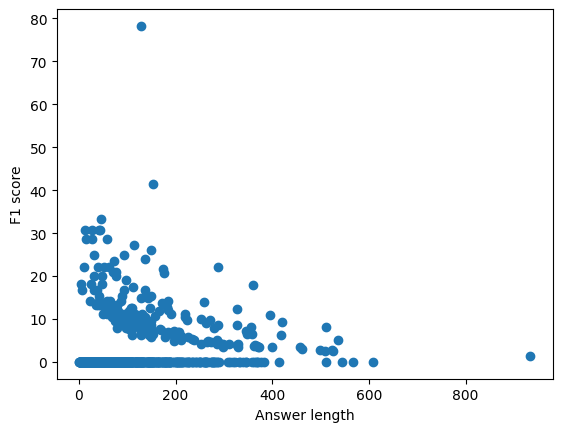

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


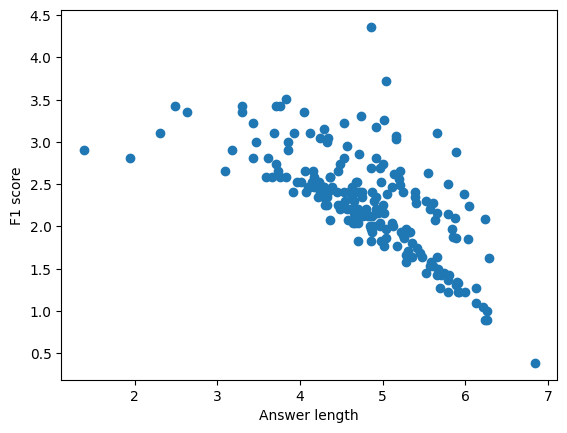

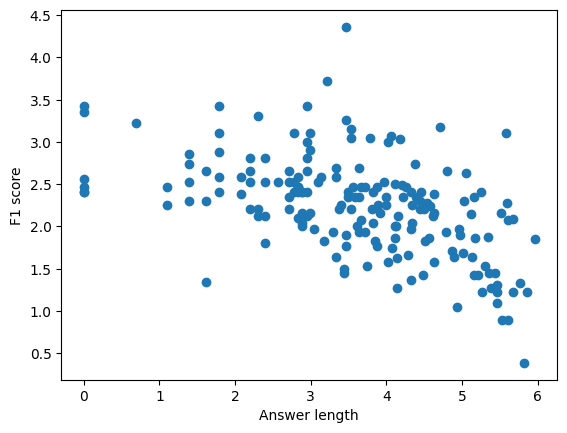

In [20]:
ASSESS_PIPELINE = True
random.seed(42)
idxs = random.sample(range(len(train)), 1_000)
_train = train.select(idxs)
if ASSESS_PIPELINE:
    question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)

    train_exact = []
    train_f1 = []
    for i_v,p_v in tqdm(
        zip(
            iter(_train),
            question_answerer(iter(_train.select_columns(["question", "context"])))
            ),
        total=_train.shape[0]
        ):
        _out = pipeline_to_squad(pred=p_v, true=i_v)
        train_exact.append(_out["exact_match"])
        train_f1.append(_out["f1"])

    print(f"Train exact mean: {np.mean(train_exact)}")
    print(f"Train exact std: {np.std(train_exact)}")
    print(f"Train f1 mean: {np.mean(train_f1)}")
    print(f"Train f1 std: {np.std(train_f1)}")

    train_df = pd.DataFrame({
        "train_f1": train_f1,
        "train_idx": idxs
        }
    )
    train_df = train_df.sort_values(by="train_f1", ascending=False)

    answer_len = []
    pred_ans_strt = []
    question = []
    answer = []
    pred_answer = []
    for i,f1 in tqdm(zip(train_df["train_idx"], train_df["train_f1"])):
      question.append(train[i]["question"])
      _pred_ans = question_answerer(train[i]["question"], train[i]["answer"])["answer"]
      pred_answer.append(_pred_ans)
      _true_ans = train[i]["answer"]
      answer.append(_true_ans)
      answer_len.append(len(_true_ans))
      _pred_ans_start = _true_ans.find(_pred_ans)
      pred_ans_strt.append(_pred_ans_start)
    train_df["answer_len"] = answer_len
    train_df["pred_ans_strt"] = pred_ans_strt
    train_df["question"] = question
    train_df["answer"] = answer
    train_df["pred_answer"] = pred_answer

    plt.scatter(train_df["answer_len"], train_df["train_f1"])
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

    plt.scatter(np.log(train_df["answer_len"]), np.log(train_df["train_f1"]))
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

    plt.scatter(np.log(train_df["pred_ans_strt"]), np.log(train_df["train_f1"]))
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

Device set to use cuda:0
100%|██████████| 182/182 [01:16<00:00,  2.37it/s]


Train exact mean: 0.0
Train exact std: 0.0
Train f1 mean: 1.4799457734407264
Train f1 std: 4.282072610893255
103
25.0
25.0
Predicted answer: {'score': 0.010815577581524849, 'start': 9, 'end': 10, 'answer': '-'}
True answer: reased 21-fold (95% CI: 18


0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
182it [00:02, 90.47it/s]


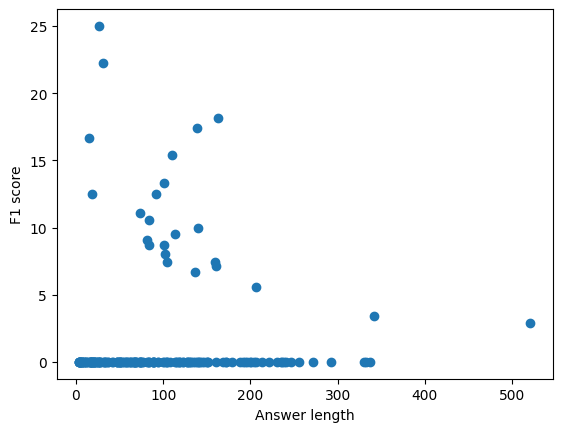

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


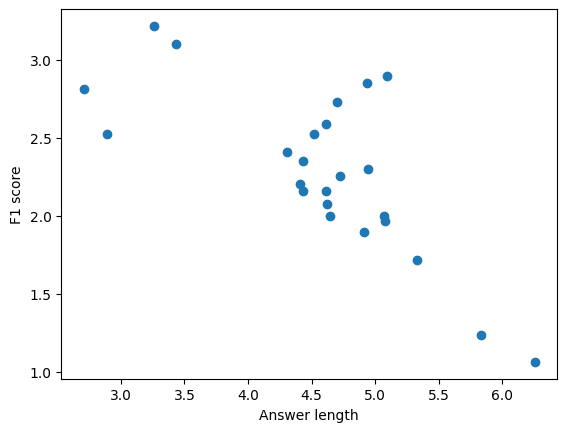

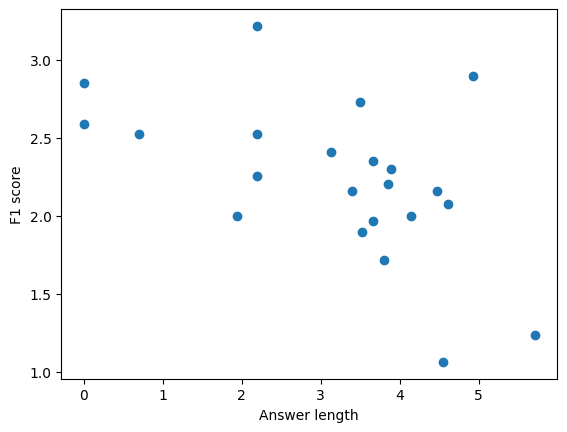

In [41]:
ASSESS_PIPELINE = True
if ASSESS_PIPELINE:
    question_answerer = pipeline("question-answering", model=model, tokenizer=tokenizer)
    val_exact = []
    val_f1 = []
    for i_v,p_v in tqdm(
        zip(
            iter(validation),
            question_answerer(iter(validation.select_columns(["question", "context"])))
            ),
        total=validation.shape[0]
        ):
        _out = pipeline_to_squad(pred=p_v, true=i_v)
        val_exact.append(_out["exact_match"])
        val_f1.append(_out["f1"])

    print(f"Train exact mean: {np.mean(val_exact)}")
    print(f"Train exact std: {np.std(val_exact)}")
    print(f"Train f1 mean: {np.mean(val_f1)}")
    print(f"Train f1 std: {np.std(val_f1)}")

    print(val_f1.index(max(val_f1)))
    _best_idx = val_f1.index(max(val_f1))
    print(max(val_f1))
    print(val_f1[_best_idx])
    print(f'Predicted answer: {question_answerer(validation[_best_idx]["question"], validation[_best_idx]["answer"])}')
    print(f'True answer: {validation[_best_idx]["answer"]}')

    val_df = pd.DataFrame(
        {"val_f1": val_f1}
    )
    val_df = val_df.reset_index(drop=False).rename(columns={"index":"val_idx"})
    val_df = val_df.sort_values(by="val_f1", ascending=False)

    answer_len = []
    pred_ans_strt = []
    question = []
    answer = []
    pred_answer = []
    for i,f1 in tqdm(zip(val_df["val_idx"], val_df["val_f1"])):
      question.append(validation[i]["question"])
      _pred_ans = question_answerer(validation[i]["question"], validation[i]["answer"])["answer"]
      pred_answer.append(_pred_ans)
      _true_ans = validation[i]["answer"]
      answer.append(_true_ans)
      answer_len.append(len(_true_ans))
      _pred_ans_start = _true_ans.find(_pred_ans)
      pred_ans_strt.append(_pred_ans_start)
    val_df["answer_len"] = answer_len
    val_df["pred_ans_strt"] = pred_ans_strt
    val_df["question"] = question
    val_df["answer"] = answer
    val_df["pred_answer"] = pred_answer

    plt.scatter(val_df["answer_len"], val_df["val_f1"])
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

    plt.scatter(np.log(val_df["answer_len"]), np.log(val_df["val_f1"]))
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

    plt.scatter(np.log(val_df["pred_ans_strt"]), np.log(val_df["val_f1"]))
    plt.xlabel("Answer length")
    plt.ylabel("F1 score")
    plt.show()

1635it [00:00, 11879.84it/s]


0.00      1.0
0.05      5.0
0.25     22.0
0.50     63.0
0.75    129.0
0.95    297.6
1.00    934.0
dtype: float64


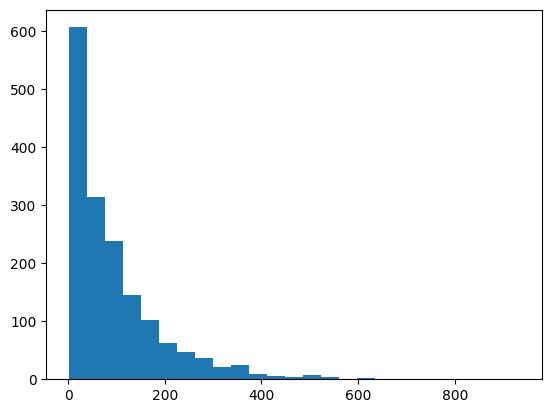

In [22]:
train_ans_len = []
for i in tqdm(iter(train)):
  train_ans_len.append(len(i["answer"]))
train_ans_len = pd.Series(train_ans_len)
print(train_ans_len.quantile([0,.05,.25,.5,.75,.95,1]))
plt.hist(train_ans_len, bins=25)
plt.show()

In [19]:
config = LoraConfig(
    r=128,
    lora_alpha=128,
    target_modules=["query","value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=['qa_outputs.bias', 'qa_outputs.weight'],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 4718592 || all params: 112439810 || trainable%: 4.20


### Data preprocessing

For the Q&A task, we'll need to do a little bit of preprocessing. Firstly, the question+context lengths overflow the  maximum context of BERT (and will overflow to a greater extent if we reduce the max sequence length to enable single GPU training (as performed below)). To handle this, we'll split large contexts across multiple new observations. Additionally, rather than niavely splitting which could result in observations where the context contains only the answer, we'll pad instances with surrounding context. We set:
* max_length to define the maximum input length;
* stride to define the context padding;
* return_overflowing_tokens to help us identify which splits corrospond to which answers in the orignal input data;
* return_offsets_mapping to help to identify where the inputs have been split;

Using this approach, we may still have inputs where an answer is not present/incomplete.

In [20]:
context =[
    "London is a very popular city with lots to do. London is the capital of England.",
    "The most popular type of beans are baked"
    ]
_token_input = tokenizer(
    ["What is the capital of England?", "What are the most popular type of beans?"],
    context,
    max_length=128,
    truncation="only_second",
    return_offsets_mapping=True,
    padding="max_length",
    stride=64,
    return_overflowing_tokens=True,
    return_tensors="pt",
    add_special_tokens = True,
    )
answer = ["London is the capital of England.","Kidney"]
print(_token_input.keys())
answer_start = [c.find(a) for c,a in zip(context,answer)]
answer_end = [a_s+len(a) if a_s!=-1 else a_s for  a_s,a in zip(answer_start,answer)]
print(context[0][answer_start[0]:answer_end[0]])
print(tokenizer.decode(_token_input["input_ids"][0]))
# Offset mapping has dimensions: (sample, trajectory length, start/end)
offset_mapping = _token_input.pop("offset_mapping")
# overflow_to_sample_mapping defines the original input to which the sample belongs
sample_map = _token_input.pop("overflow_to_sample_mapping")
print(sample_map)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'overflow_to_sample_mapping'])
London is the capital of England.
[CLS] What is the capital of England? [SEP] London is a very popular city with lots to do. London is the capital of England. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
tensor([0, 1])


In [21]:
print(_token_input["attention_mask"][1,:])
print(_token_input["input_ids"][1,:])
print(tokenizer.decode(_token_input["input_ids"][1,:]))

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
tensor([  101,  1327,  1132,  1103,  1211,  1927,  2076,  1104, 15154,   136,
          102,  1109,  1211,  1927,  2076,  1104, 15154,  1132, 19983,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,

In [22]:
def find_labels(offset, answer_start, answer_end, sequence_ids):
    idx = 0
    # The context is defined by 1
    question_start = idx
    while sequence_ids[idx] is None:
        if idx < len(sequence_ids)-1:
          idx += 1
    question_start = idx
    while sequence_ids[idx] != 1:
        if idx < len(sequence_ids)-1:
          idx += 1
        else:
          break
    context_start = idx
    while sequence_ids[idx] == 1:
        if idx < len(sequence_ids)-1:
          idx += 1
        else:
          break
    context_end = idx - 1
    # If the answer is not fully inside the context, label it (0, 0)
    if offset[context_start][0] > answer_end or offset[context_end][1] < answer_start:
        start_positions = question_start
        end_positions = question_start
    else:
        # Otherwise it's the start and end token positions
        idx = context_start
        while idx <= context_end and offset[idx][0] <= answer_start:
            idx += 1
        start_positions = idx - 1

        idx = context_end
        while idx >= context_start and offset[idx][1] >= answer_end:
            idx -= 1
        end_positions = idx + 1
    return start_positions, end_positions

In [23]:
def preprocess_function(
    tokenised_dataset:transformers.tokenization_utils_base.BatchEncoding,
    answer_start,
    answer_end
    ):
    # Offset mapping has dimensions: (sample, trajectory length, start/end)
    offset_mapping = tokenised_dataset.pop("offset_mapping")
    # overflow_to_sample_mapping defines the original input to which the sample belongs
    sample_map = tokenised_dataset.pop("overflow_to_sample_mapping")
    start_positions = []
    end_positions = []
    for i in tqdm(
        range(tokenised_dataset["input_ids"].shape[0]),
        total=tokenised_dataset["input_ids"].shape[0]
        ):
          _seq_ids = tokenised_dataset.sequence_ids(i)
          _ans_id = sample_map[i].item()
          _lab = find_labels(
              offset=offset_mapping[i,:],
              answer_start=answer_start[_ans_id],
              answer_end=answer_end[_ans_id],
              sequence_ids=_seq_ids
          )
          start_positions.append(_lab[0])
          end_positions.append(_lab[1])

    tokenised_dataset["start_positions"] = torch.tensor(start_positions).reshape(-1,1)
    tokenised_dataset["end_positions"] = torch.tensor(end_positions).reshape(-1,1)
    return tokenised_dataset

In [24]:
start_positions = []
end_positions = []
for i in range(_token_input["input_ids"].shape[0]):
  _seq_ids = _token_input.sequence_ids(i)
  _ans_id = sample_map[i].item()
  _lab = find_labels(
      offset=offset_mapping[i,:],
      answer_start=answer_start[_ans_id],
      answer_end=answer_end[_ans_id],
      sequence_ids=_seq_ids
  )
  start_positions.append(_lab[0])
  end_positions.append(_lab[1])


### Modelling

In [25]:
max_length = 512
stride = 128

In [26]:
questions = [q.strip() for q in train["question"]]
tokenised_dataset = tokenizer(
    questions,
    train["context"],
    max_length=max_length,
    truncation="only_second",
    return_offsets_mapping=True,
    padding="max_length",
    stride=stride,
    return_overflowing_tokens=True,
    return_tensors="pt",
    add_special_tokens = True
    )
tokenized_train = preprocess_function(
    tokenised_dataset=tokenised_dataset,
    answer_start=train["answer_start"],
    answer_end=train["answer_end"]
    )
tokenized_train = Dataset.from_dict(tokenized_train)

100%|██████████| 34688/34688 [00:14<00:00, 2330.79it/s]


In [27]:
questions = [q.strip() for q in validation["question"]]
tokenised_dataset = tokenizer(
    questions,
    validation["context"],
    max_length=max_length,
    truncation="only_second",
    return_offsets_mapping=True, # Tokens corrospond to multiple input characters
    padding="max_length",
    stride=stride,
    return_overflowing_tokens=True,
    return_tensors="pt",
    add_special_tokens = True
    )
tokenized_val = preprocess_function(
    tokenised_dataset=tokenised_dataset,
    answer_start=validation["answer_start"],
    answer_end=validation["answer_end"]
    )
tokenized_val = Dataset.from_dict(tokenized_val)

100%|██████████| 4044/4044 [00:02<00:00, 1355.50it/s]


In [28]:
from transformers import DefaultDataCollator
data_collator = DefaultDataCollator()

In [29]:
model_name = model_checkpoint.split("/")[-1]

In [30]:
batch_size = 32
grad_accum = 32

args = TrainingArguments(
    f"{model_name}-finetuned-health-qa",
    remove_unused_columns=False,
    eval_strategy="epoch", # How often to evaluate the model on the validation set i.e., after every epoch
    save_strategy="epoch", # How often to save model checkpoints i.e., after every epoch
    learning_rate=1e-3,
    per_device_train_batch_size=batch_size, # Effective batch size (equals the actual batch size when using a single GPU)
    gradient_accumulation_steps=min([batch_size, grad_accum]), #How many forward passes to perform before performing backprop and caching gradients
    per_device_eval_batch_size=batch_size, # Effective batch size (equals the actual batch size when using a single GPU)
    fp16=True, # Train with floating point 16, reducing the memory requirements
    num_train_epochs=15,
    logging_steps=10,
    #load_best_model_at_end=True,
    #metric_for_best_model="accuracy",
    push_to_hub=True,
    report_to="wandb",
    label_names = ["start_positions","end_positions"]
)

In [31]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator
)

In [32]:
train_results = trainer.train()
wandb.finish()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss
1,0.657700,0.625178
2,0.621400,0.587709
3,0.568300,0.569229
4,0.461500,0.457902
5,0.413100,0.407633
6,0.381100,0.378930
7,0.344100,0.365492
8,0.304200,0.378612
9,0.296000,0.348103
10,0.276400,0.365460


wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-34)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-68)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-102)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-136)... Done. 0.2s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-170)... Done. 0.2s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-204)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-238)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-272)... Done. 0.1s
wandb: Adding directory to artifact (./bert-base-cased-finetuned-health-qa/checkpoint-306)... Done. 0.2s
wandb: Adding directory to artifact (./bert-base-cased-fi

eval/loss,█▇▇▄▃▂▁▂▁▁▁▁▂▂▂
eval/runtime,▄▂▅▁▂▂▂▁▄▃▁▂▂▆█
eval/samples_per_second,▅▇▄█▇▇▇█▅▆█▇▇▃▁
eval/steps_per_second,▅▇▄█▇▇▇█▅▆█▇▇▃▁
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train/grad_norm,█▁ ▂▁▃▃▂▂▂▃▂▂▃▃▂▃▂▂▂▃▂▄▂▃▂▂▂▃▂▃▂▂▂▂▂▂▂▂▂
train/learning_rate,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁
train/loss,█▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/loss,0.37389
eval/runtime,8.5404


In [33]:
repo_name = f"joshuaspear/{model_name}-finetuned-health-qa"

In [34]:
from peft import PeftConfig, PeftModel


config = PeftConfig.from_pretrained(repo_name)
model = AutoModelForQuestionAnswering.from_pretrained(
    config.base_model_name_or_path,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


adapter_config.json:   0%|          | 0.00/797 [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
ASSESS_PIPELINE = True
if ASSESS_PIPELINE:
    val_exact = []
    val_f1 = []
    for i_v,p_v in tqdm(
        zip(
            iter(validation),
            question_answerer(iter(validation.select_columns(["question", "context"])))
            ),
        total=validation.shape[0]
        ):
        _out = pipeline_to_squad(pred=p_v, true=i_v)
        val_exact.append(_out["exact_match"])
        val_f1.append(_out["f1"])

    print(np.mean(val_exact))
    print(np.std(val_exact))
    print(np.mean(val_f1))
    print(np.std(val_f1))

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/question_answering.py:391: FutureWarning: Passing a list of SQuAD examples to the pipeline is deprecated and will be removed in v5. Inputs should be passed using the `question` and `context` keyword arguments instead.
  warnings.warn(
100%|██████████| 182/182 [01:42<00:00,  1.77it/s]

4.945054945054945
21.68068094170204
17.826946535999653
28.83600504614835
